In [70]:
# 전처리한 데이터 불러오기
import pandas as pd

df = pd.read_csv('C://Users//and_c//Desktop//sparta_ga4//train_df3.csv', low_memory = False)

In [71]:
# 해당 값 전체 보기 설정
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_columns = None

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   fullVisitorId              903653 non-null  object 
 1   channelGrouping            903653 non-null  object 
 2   visitStartTime             903653 non-null  int64  
 3   device_browser             903653 non-null  object 
 4   device_operatingSystem     903653 non-null  object 
 5   device_deviceCategory      903653 non-null  object 
 6   geoNetwork_continent       903653 non-null  object 
 7   geoNetwork_subContinent    903653 non-null  object 
 8   geoNetwork_country         903653 non-null  object 
 9   totals_visits              903653 non-null  int64  
 10  totals_hits                903653 non-null  int64  
 11  totals_bounces             903653 non-null  float64
 12  totals_newVisits           903653 non-null  float64
 13  totals_transactionRevenue  90

In [73]:
# 데이터프레임에 한 열의 값을 바꾸기 위해서 def함수를 만들고 apply 적용
import pandas as pd
import datetime #날짜와 시간을 다루는 라이브러리
import pytz #다양한 시간대를 처리하기 위해 사용하는 라이브러리

# Posix 시간을 utc 시간으로 변환하는 함수
def posix_to_utc(visitStartTime):
    utc_time = datetime.datetime.utcfromtimestamp(visitStartTime)
    return utc_time

# Posix 시간을 UTC 지정한 로컬 시간대로 변환하는 함수
def posix_to_utc_local(visitStartTime):
    utc_time = datetime.datetime.utcfromtimestamp(visitStartTime) #posix -> utc시간대로
    local_timezone = pytz.timezone('America/New_York')  # 지역 시간대
    return utc_time.astimezone(local_timezone) # 그 지역 시간대로 변환

In [74]:
df['visitStartTime'] = df['visitStartTime'].apply(posix_to_utc)

DAU / WAU / MAU를 Line Char로 시각화

In [75]:
import matplotlib.pyplot as plt

In [76]:
# DAU구하기
# df['date'] = df['visitStartTime'].dt.strftime('%Y-%m-%d')
df['date'] = df['visitStartTime'].dt.date

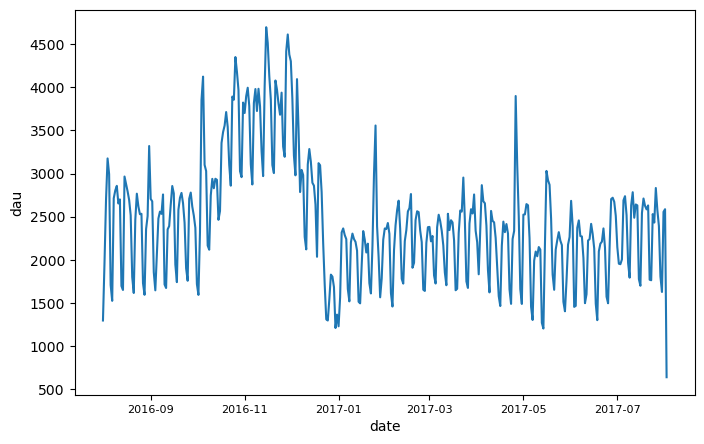

In [116]:
# dau_df = df.groupby(df['date'])[['fullVisitorId']].count()
dau_df = df['date'].value_counts().sort_index()

plt.figure(figsize = (8,5))
# plt.plot(dau_df.index, dau_df['fullVisitorId'])
plt.plot(dau_df.index, dau_df.values)
plt.xlabel('date')
plt.ylabel('dau')
plt.xticks(fontsize=8)
plt.show()

In [78]:
# WAU구하기
df['period_week'] = df['visitStartTime'].dt.to_period("W")

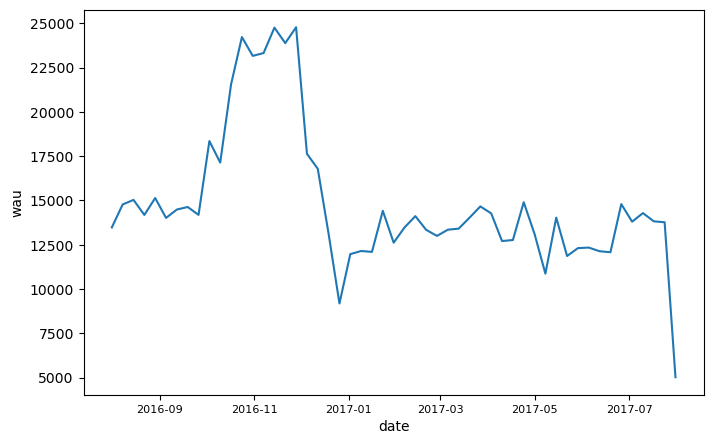

In [115]:
# WAU구하기
# wau_df = df.groupby(df['visitStartTime','year'].dt.week)[['fullVisitorId']].nunique()
wau_df = df.groupby('period_week')[['fullVisitorId']].nunique()
# period값을 to_timestamp를 사용해 주기의 시작값으로 변환
wau_df.index = wau_df.index.to_timestamp()

plt.figure(figsize = (8,5))
plt.plot(wau_df.index, wau_df['fullVisitorId'])
plt.xlabel('date')
plt.ylabel('wau')
plt.xticks(fontsize=8)
plt.show()

In [80]:
# MAU구하기
# df['period_month'] = df['visitStartTime'].dt.to_period("M")
df['period_month'] = df['visitStartTime'].dt.strftime('%Y-%m')

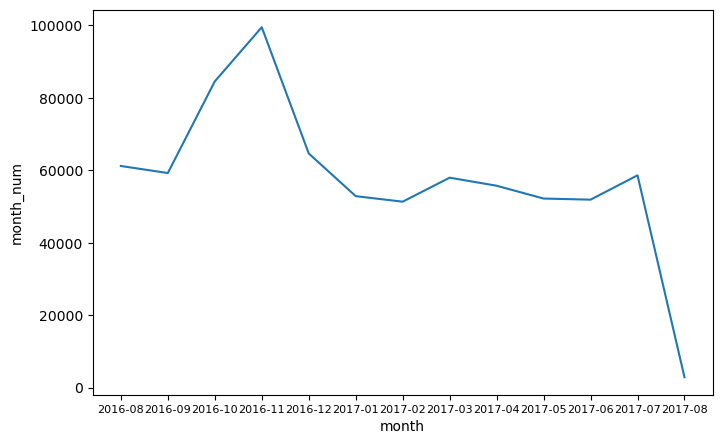

In [114]:
# 월을 기준으로 계산
month_df = df.groupby('period_month')[['fullVisitorId']].nunique()

plt.figure(figsize = (8,5))
plt.plot(month_df.index, month_df['fullVisitorId'])
plt.xlabel('month')
plt.ylabel('month_num')
plt.xticks(fontsize=8)
plt.show()

- 10~12월에 접속량 증가

유저별 평균접속시간 분포 경험적 누적 분포 함수(ECDF : Emperical Cumulative distribution function)로 시각화

In [82]:
# # 실행시간이 너무 오래 걸려서 PASS
# def min_max(x):
#     return x.max()-x.min()

# df.groupby(['fullVisitorId','date'])['visitStartTime'].agg(min_max)

In [83]:
first_visit = df.groupby(['fullVisitorId','date'])['visitStartTime'].min()
last_visit = df.groupby(['fullVisitorId','date'])['visitStartTime'].max()

In [128]:
#1day -> timedelta형식은 plt로 시각화할 수 없어서 total_seconds()를 통해 float으로 변환
diff_visit = (last_visit-first_visit).dt.total_seconds()

In [129]:
# 전체 머무른 시간 / 접속한 횟수
average_visit = diff_visit.groupby('fullVisitorId').sum() / diff_visit.groupby('fullVisitorId').count()

In [130]:
average_visit.tail()

fullVisitorId
9999963186378918199    0.0
999997225970956660     0.0
999997550040396460     0.0
9999978264901065827    0.0
9999986437109498564    0.0
Name: visitStartTime, dtype: float64

- ex. 1시간 혹은 2~3시간 뒤에 다시 접속한 경우가 있으면..?에 관한 의문

ECDF
- 주어진 데이터 집합의 누적 분포를 표현하는 통계적 도구
- ECDF는 각 데이터 포인트가 발생할 확률을 나타내는 대신, 주어진 값보다 작거나 같은 값이 발생할 확률을 표시

In [131]:
# ECDF 구하기
# 정렬
average_visit.sort_values(inplace = True)
# 개수 구하기
import numpy as np
n = len(average_visit)
y = np.arange(1, n+1)/n

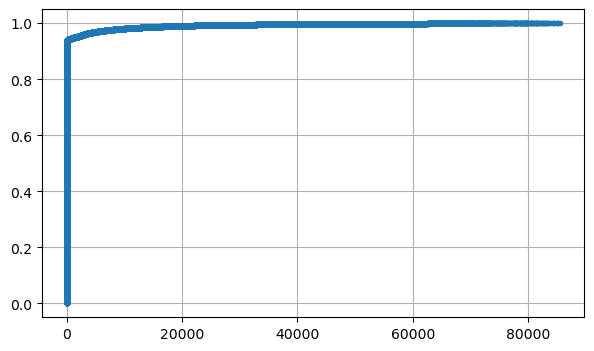

In [132]:
plt.figure(figsize=(7,4))
plt.plot(average_visit,y,marker = '.', linestyle = 'none')
plt.grid(True)
plt.show()

In [137]:
# 하루에 1번만 접속한 사람은 제외해서 계산해보기
from datetime import timedelta
a = average_visit[average_visit != 0]

import numpy as np
n = len(a)
y = np.arange(1, n+1)/n

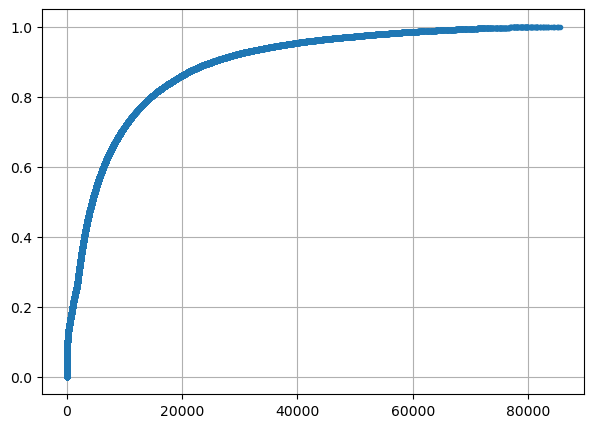

In [138]:
plt.figure(figsize=(7,5))
plt.plot(a,y,marker = '.', linestyle = 'none')
plt.grid(True)
plt.show()

In [139]:
# 데이터프레임으로 만들기
average_visit_df = pd.DataFrame({'user_id' : average_visit.index, 'duration' : average_visit.values})

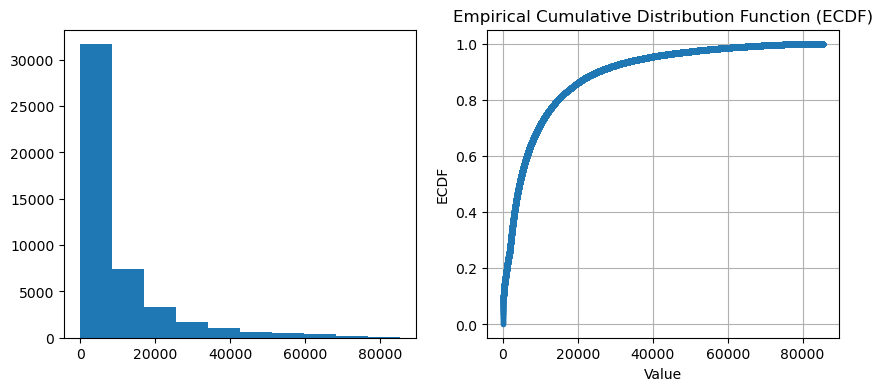

In [152]:
from scipy import stats

# Return a cumulative frequency histogram, using the histogram function.
ecdf = stats.cumfreq(a, numbins=len(a))

# x 축 값 설정 (데이터 정렬)
x = ecdf.lowerlimit + np.linspace(0, ecdf.binsize * ecdf.cumcount.size, ecdf.cumcount.size)

# 시각화
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(a.values)
ax2.plot(x, ecdf.cumcount / len(a), marker='.', linestyle='-')
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function (ECDF)')
plt.grid(True)
plt.show()

방문 주차에 따른 코호트를 생성하고, 코호트 별로 weekly 리텐션을 구하고 이를 heatmap으로 시각화

In [175]:
# newvisit기준으로 신규유입자 구분?
df.groupby('totals_newVisits')['fullVisitorId'].count()

totals_newVisits
0.0    200593
1.0    703060
Name: fullVisitorId, dtype: int64

In [ ]:
# week 칼럼 만들기 -> 비교하는 칼럼 만들기
# df['week'] = df['visitStartTime'].dt.week
month_df = df.groupby('period_month')[['fullVisitorId']].nunique()
# retention = 지난주 접속자 수 / 이번주 접속자 수
# 어렵네요..
# n = len(wau_df) # 53


In [ ]:
# plt.rcParams['figure.figsize'] = [10,8]
# plt.pcolor(table)
# # 또는 sns.heatmap()
# # 피벗테이블의 df를 pandas를 이용해 표현도 가능 df.style.background_gradient
# plt.title('Weekly Retention', fontsize=20)
# plt.xlabel('week', fontsize=14)
# plt.ylabel('visit', fontsize=14)
# plt.colorbar()

이런 형태의 히트맵..    
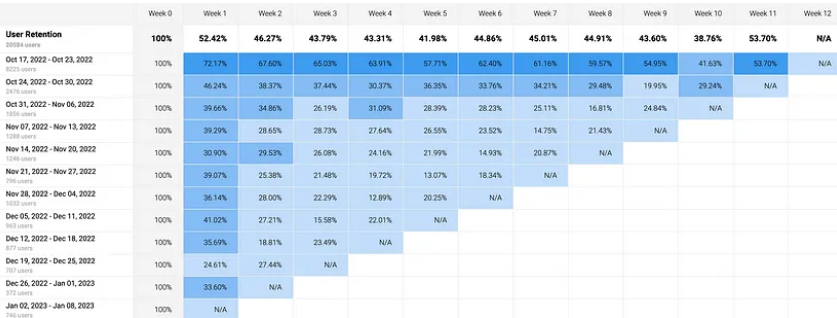

Carrying Capapcity

In [ ]:
# Wau / (1-retention)
# print(wau_df)


국가별 DAU 평균을 Folium으로 시각화하기

In [181]:
# df.groupby('geoNetwork_continent')

country = df['geoNetwork_country'].unique()

# 국가별 DAu평균 구하기
check = {}
for i in country:
    check[i] = round(df[df['geoNetwork_country'] == i]['date'].value_counts().mean(),1)

In [182]:
check

{'Turkey': 55.92,
 'Australia': 34.6,
 'Spain': 31.77,
 'Indonesia': 25.27,
 'United Kingdom': 101.89,
 'Italy': 30.88,
 'Pakistan': 10.93,
 'Austria': 7.64,
 'Netherlands': 31.21,
 'India': 139.35,
 'France': 43.14,
 'Brazil': 53.9,
 'China': 10.57,
 'Singapore': 19.54,
 'Argentina': 13.72,
 'Poland': 26.41,
 'Germany': 54.44,
 'Canada': 70.49,
 'Thailand': 54.83,
 'Hungary': 6.94,
 'Malaysia': 17.54,
 'Denmark': 9.07,
 'Taiwan': 35.41,
 'Russia': 31.78,
 'Nigeria': 4.12,
 'Belgium': 12.1,
 'South Korea': 14.27,
 'Chile': 5.39,
 'Ireland': 17.74,
 'Philippines': 25.19,
 'Greece': 9.21,
 'Mexico': 36.04,
 'Montenegro': 1.22,
 'United States': 993.85,
 'Bangladesh': 6.36,
 'Japan': 53.76,
 'Slovenia': 2.43,
 'Czechia': 11.64,
 'Sweden': 14.48,
 'United Arab Emirates': 8.59,
 'Switzerland': 12.06,
 'Portugal': 6.58,
 'Peru': 15.19,
 'Hong Kong': 12.86,
 'Vietnam': 67.02,
 'Sri Lanka': 4.18,
 'Serbia': 5.41,
 'Norway': 6.23,
 'Romania': 17.56,
 'Kenya': 2.74,
 'Ukraine': 15.2,
 'Israel': 

캠페인 효과 분석: 캠페인으로 들어온 사람은 다른 사람과 다른 특징을 가지고 있는지 분석해보기

In [177]:
# 캠페인 종류 확인
campaign = df['trafficSource_campaign'].unique()
campaign

array(['(not set)', 'AW - Dynamic Search Ads Whole Site',
       'Data Share Promo', 'AW - Electronics', 'test-liyuhz',
       'AW - Accessories',
       'Retail (DO NOT EDIT owners nophakun and tianyu)', 'AW - Apparel',
       'All Products', 'Data Share'], dtype=object)